
![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)




In [1]:
# !pip3 install torch>=1.3.0
# !pip3 install subword-nmt &> log
# !wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
# !wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py -O vocab.py
# thanks to tilda and deephack teams for the data, Dmitry Emelyanenko for the code :)

--2021-11-20 14:10:32--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com... 162.125.70.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com|162.125.70.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/yy2zqh34dyhv07i/data.txt [following]
--2021-11-20 14:10:33--  https://www.dropbox.com/s/dl/yy2zqh34dyhv07i/data.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucccd76215c759abbcb087063a94.dl.dropboxusercontent.com/cd/0/get/BaVKe9xH6C-4Ryc-EUeLCPxwqPkLUUuy_Z8Iy6fdYC98dD4iW83IRWrxQ3yGvFsnBstq1Wo-nFiGPakWFGv3xkRon2QXMLpI-KjkLpiDVZk2FYJs8OmZMriZNl3Ic-PIIAQTriP2Z_NiUkzWeTVtdUqQ/file?dl=1# [following]
--2021-11-20 14:10:33--  https://ucccd76215c759abbcb087063a94.dl.dropboxusercontent.com/cd/0/get/BaVKe9xH6C-4Ryc-EUeLCPxwqPkLUUuy_Z8Iy6fdYC98dD4iW83IRWrxQ3yGvFsnBstq1Wo-nFiGPakWFGv3xkRon2QXMLpI-KjkLpiDVZk2FYJs8OmZMriZNl3Ic-PIIAQTr

In [3]:
# !pip install subword-nmt

In [1]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [4]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [5]:
# Here's how you cast lines into ids and backwards.
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


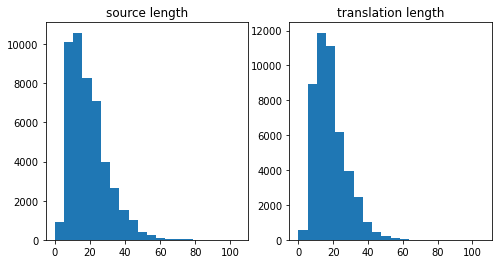

In [6]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

In [9]:
dummy_inp_tokens

tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]], device='cuda:0')

In [10]:
inp_voc.compute_mask(dummy_inp_tokens)

tensor([[ True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False]],
       device='cuda:0')

In [11]:
dummy_out_tokens

tensor([[   0, 6592, 3191, 6214,   23,    1,    1],
        [   0, 7323, 3434, 2667,   23,    1,    1],
        [   0, 2145, 3049,  190, 6858,   23,    1],
        [   0, 4890, 3434, 2667,   23,    1,    1],
        [   0, 4890, 3434, 2667,   23,    1,    1]], device='cuda:0')

In [12]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__() # initialize base class to track sub-layers, parameters, etc.

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        
    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        
        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
#         ^-- shape: [batch_size, hid_size]
        
        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]
        
        new_gru0_state = self.dec0(self.emb_out(prev_tokens), prev_gru0_state)
        new_dec_state = [new_gru0_state]
        output_logits = self.logits(new_gru0_state)
        return new_dec_state, output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state
        
        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, 
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        
        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return out_voc.to_lines(out_ids.cpu().numpy()), states


In [13]:
# debugging area
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))


In [14]:
# debugging area
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [15]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
siófok igl@@ hood cent@@ distance ten spoilt 60 home@@ lis perugia su ship zlat@@ ms locanda dach@@ rustaveli lan horn vendégház ham mem@@ snacks largest
siófok igl@@ hood cent@@ distance ten spoilt 60 home@@ lis perugia su ship zlat@@ ms locanda dach@@ rustaveli lan horn vendégház ham mem@@ snacks largest
siófok igl@@ hood cent@@ distance ten spoilt 60 home@@ lis perugia su ship zlat@@ ms locanda dach@@ rustaveli lan horn vendégház ham mem@@ snacks largest


In [16]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)
    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)
   
    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    return -torch.masked_select(logp_out, mask).mean() # average loss, scalar

In [17]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.4977, device='cuda:0', grad_fn=<NegBackward>)


### Evaluation: BLEU

In [18]:
from nltk.translate.bleu_score import corpus_bleu
from copy import deepcopy
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    Note: if you're serious about reporting your results, use https://pypi.org/project/sacrebleu
    """
    it, batch_size = 0, 200
    translations = []
    while it < len(inp_lines):
        batch_translations, _ = model.translate_lines(inp_lines[it:it + batch_size], **flags)
        translations += batch_translations
        it += batch_size
        print(it, "/", len(inp_lines))
    translations = [line.replace(bpe_sep, '') for line in translations] 
    return corpus_bleu(
        [[ref.split()] for ref in out_lines],
        [trans.split() for trans in translations],
        smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

In [19]:
compute_bleu(model, dev_inp, dev_out)

200 / 3000
400 / 3000
600 / 3000
800 / 3000
1000 / 3000
1200 / 3000
1400 / 3000
1600 / 3000
1800 / 3000
2000 / 3000
2200 / 3000
2400 / 3000
2600 / 3000
2800 / 3000
3000 / 3000


0.0023583528994869612

### Training loop

In [20]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BasicModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

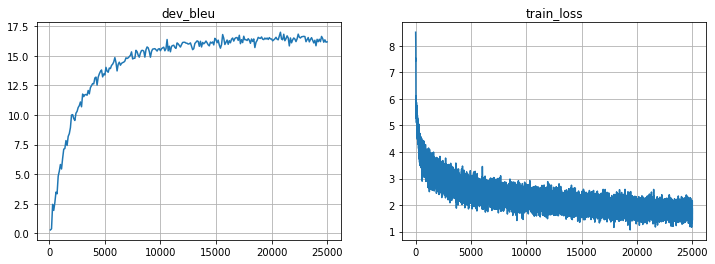

Mean loss=1.737


100%|██████████| 25000/25000 [17:19<00:00, 24.04it/s]


In [21]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)
    
    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()
    
    
    metrics['train_loss'].append((step, loss_t.item()))
    
    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [22]:
np.mean(metrics['dev_bleu'][-10:], axis=0)[1]

16.304046643964153

In [23]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen and a shared kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
the property offers free parking and a 24 - hour front desk .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
lit@@ al@@ ca is 26 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
offering a sun terrace with a sun terrace , a sun terrace and a sun terrace , the beachfront location is a 5 - minute walk from the beach .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
apartament emil@@ ion apartments is located in prague district , 200 metres from the louvre museum .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
private bathroom comes with a shower and towels .



### Attention layer 

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Get probabilities from logits, 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

 [from this post](https://distill.pub/2016/augmented-rnns/).

In [24]:
from torch.nn.utils.rnn import pad_sequence
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size, activ=torch.tanh):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.name = name
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity
        
        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.inf = nn.Parameter(torch.tensor(-1e9), requires_grad=False)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """

        
        logits = self.linear_out(self.activ((self.linear_enc(enc) + self.linear_dec(dec).unsqueeze(1)))).squeeze(2)[:,:enc.shape[1]]
        
        
        logits = torch.where(inp_mask.byte(), logits.float(), self.inf)

    
        probs = torch.softmax(logits, -1) # [batch_size, ninp]
        
        attn = (enc * probs.unsqueeze(2)).sum(dim=1)
        return attn, probs

### Seq2seq model with attention


![img](https://i.imgur.com/6fKHlHb.png)





In [25]:
class AttentiveModel(BasicModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        nn.Module.__init__(self)  
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.attention = AttentionLayer(" ", attn_size, attn_size, hid_size).to(device)
        self.linear_logits = nn.Linear(attn_size + hid_size, len(out_voc))

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        
        dec_start = self.dec_start(last_state)
        
        mask = self.inp_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, mask)
        
        
        first_state = [dec_start, enc_seq, mask, first_attn_probas]
        return first_state
   
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        
        dec = prev_state[0]
        enc_seq = prev_state[1]
        mask = prev_state[2]
        attn, probs = prev_state[-1] # [batch_size, enc_size] | [batch_size, ninp]
        
        new_dec = self.dec0(self.emb_out(prev_tokens), dec) # [batch_size, hid_size]
        
        output_logits = self.linear_logits(torch.cat((attn, new_dec), 1))
        
        new_attn, new_probs = self.attention(enc_seq, new_dec, mask)
        new_dec_state = [new_dec, enc_seq, mask, [new_attn, new_probs]]
        
        
        return [new_dec_state, output_logits]


### Training attentive model


In [26]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel("", inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

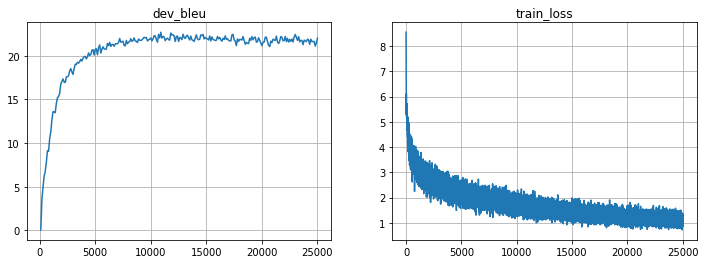

Mean loss=1.053


100%|██████████| 25000/25000 [38:26<00:00, 10.84it/s]


In [27]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)
    
    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()
    
    
    metrics['train_loss'].append((step, loss_t.item()))
    
    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


In [28]:
np.mean(metrics['dev_bleu'][-10:], axis=0)[1]

21.6524690097745

### Visualizing model attention

In [30]:
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook, show
from bokeh.models import FixedTicker
output_notebook()

def draw_attention(inp_line, translation, probs):
    """ An intentionally ambiguous function to visualize attention weights """
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    probs = probs[:len(trans_tokens), :len(inp_tokens)]
    
    fig = pl.figure(x_range=(0, len(inp_tokens)), y_range=(0, len(trans_tokens)),
                    x_axis_type=None, y_axis_type=None, tools=[])
    fig.image([probs[::-1]], 0, 0, len(inp_tokens), len(trans_tokens))

    fig.add_layout(bm.LinearAxis(axis_label='source tokens'), 'above')
    fig.xaxis.ticker = FixedTicker(ticks=np.arange(len(inp_tokens)) + 0.5)
    fig.xaxis.major_label_overrides = dict(zip(np.arange(len(inp_tokens)) + 0.5, inp_tokens))
    fig.xaxis.major_label_orientation = 45

    fig.add_layout(bm.LinearAxis(axis_label='translation tokens'), 'left')
    fig.yaxis.ticker = FixedTicker(ticks=np.arange(len(trans_tokens)) + 0.5)
    fig.yaxis.major_label_overrides = dict(zip(np.arange(len(trans_tokens)) + 0.5, trans_tokens[::-1]))

    show(fig)

ModuleNotFoundError: No module named 'bokeh'

In [49]:
inp = dev_inp[::500]

trans, states = model.translate_lines(inp)
attention_probs = np.stack([state[-1][-1].to('cpu').detach() for state in states], axis=1)

In [50]:
draw_attention(inp[0], trans[0], attention_probs[0])

In [51]:
draw_attention(inp[1], trans[1], attention_probs[1])

In [52]:
draw_attention(inp[2], trans[2], attention_probs[2])

In [53]:
draw_attention(inp[3], trans[3], attention_probs[3])

In [54]:
draw_attention(inp[4], trans[4], attention_probs[4])